In [1]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from scipy.ndimage.filters import correlate
Epsilon = 1e-7
DPI = 120
RADIUS = 2
THICKNESS = 2
COLOR = [255,0,0]

C:\Users\fadri_zkxoohp\AppData\Local\Temp\ipykernel_7996\184973183.py:5: DeprecationWarning: Please use `correlate` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import correlate


### load image and compute the gradient

In [2]:
# TODO 
input_img = cv2.imread('inputs/I1.jpg', 0) / 255
dy, dx = np.gradient(input_img)



### Compute structure tensor

In [3]:
# TODO 
# Calculate the gradient in the x and y directions
gradient_x = cv2.Sobel(input_img, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(input_img, cv2.CV_64F, 0, 1, ksize=3)

Ixx = gradient_x * gradient_x
Ixy = gradient_x * gradient_y
Iyy = gradient_y * gradient_y

Ixx = gaussian_filter(Ixx, sigma=1)
Ixy = gaussian_filter(Ixy, sigma=1)
Iyy = gaussian_filter(Iyy, sigma=1)


print(Ixx)

[[2.54958657e-05 7.46118108e-05 1.79212214e-04 ... 9.53488926e-04
  1.08547540e-03 7.12258971e-04]
 [7.30950908e-05 2.15208256e-04 5.19300486e-04 ... 8.18461153e-04
  1.00515867e-03 6.69814372e-04]
 [2.58253284e-04 6.79370519e-04 1.59596975e-03 ... 6.13339944e-04
  7.54712221e-04 4.91717795e-04]
 ...
 [8.96706200e-05 1.89936898e-04 2.96462089e-04 ... 1.06420416e-03
  6.80689430e-04 2.21923311e-04]
 [6.76559547e-05 1.14783050e-04 1.36793925e-04 ... 5.36958060e-04
  3.09951560e-04 1.09330661e-04]
 [6.67367968e-05 1.01664038e-04 9.23999466e-05 ... 4.08230493e-04
  2.03580324e-04 7.86406982e-05]]


### Compute Shi-Thomasi response and Harris response, please compare them in the end

In [4]:
from numpy import linalg as LA
# TODO 
# Constuct the matrix M out of Ixx, Ixy, Iyy
def shitomasi(img, Ixx, Iyy, Ixy):
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])

    print('M: ' , M.shape)


    sqrt_part = np.sqrt((Ixx - Iyy)**2 + 4 * Ixy**2)

    lambda1 = 0.5 * (Ixx + Iyy + sqrt_part)
    lambda2 = 0.5 * (Ixx + Iyy - sqrt_part)

    # Find the smaller eigenvalue for each pixel
    smaller_eigenvalues = np.minimum(lambda1, lambda2)

    mean_smaller_eigenvalues = np.mean(smaller_eigenvalues)

    #Eigenvalue < 5 * mean
    selected_pixels = np.where(smaller_eigenvalues > 5 * mean_smaller_eigenvalues, smaller_eigenvalues, 0)


   

    return selected_pixels #new_image


# response_harris = cv2.cornerHarris(input_img, 2, 3, 0.04)

def response_harris_diy(Ixx, Ixy, Iyy, k=0.03):
    det = Ixx * Iyy - Ixy**2
    trace = Ixx + Iyy
    return det - k * trace**2

response_harris_diy = response_harris_diy(Ixx, Ixy, Iyy)
# set every value below 0.001 to 0 and the rest to 255
# response_harris_diy = np.where(response_harris_diy < 0.001, 0, 1)
response_shitomasi = shitomasi(input_img, Ixx, Iyy, Ixy)


#show the response harris image
# plt.imshow(response_harris_diy, cmap='gray')



M:  (2, 2, 2448, 3264)


### Visualise the response map

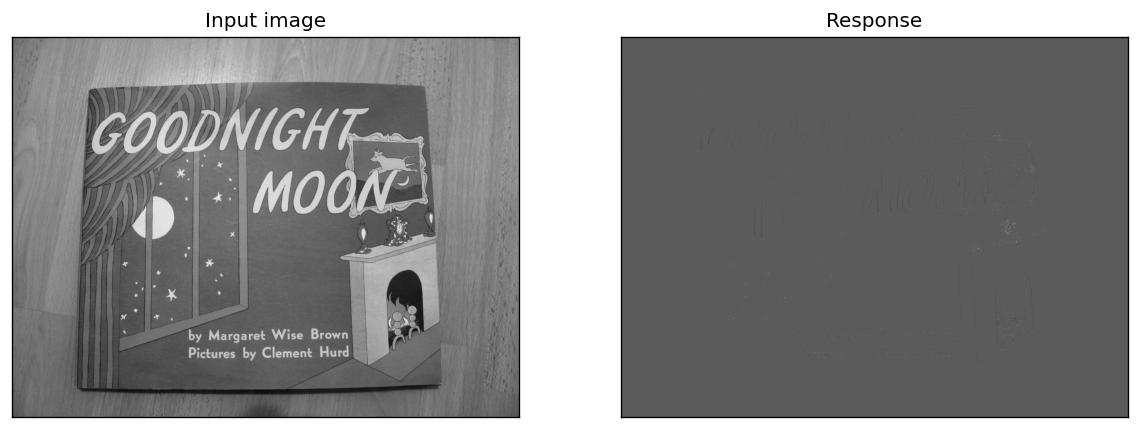

In [5]:
# choose either Shi-Tomasi or Harris response
# TODO 
response = response_harris_diy


plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(response, cmap=plt.cm.gray)
plt.title('Response')
plt.show()

### Plot the histogram of responses

(array([2806054.,  988914.,  594838.,  409928.,  301964.,  235088.,
         188843.,  155779.,  130586.,  111457.,   96203.,   84322.,
          74695.,   66692.,   59340.,   54193.,   48269.,   44268.,
          40651.,   37465.,   34472.,   32196.,   29847.,   27739.,
          25719.,   24381.,   22760.,   21418.,   20202.,   18966.]),
 array([0.00000000e+00, 3.33333333e-07, 6.66666667e-07, 1.00000000e-06,
        1.33333333e-06, 1.66666667e-06, 2.00000000e-06, 2.33333333e-06,
        2.66666667e-06, 3.00000000e-06, 3.33333333e-06, 3.66666667e-06,
        4.00000000e-06, 4.33333333e-06, 4.66666667e-06, 5.00000000e-06,
        5.33333333e-06, 5.66666667e-06, 6.00000000e-06, 6.33333333e-06,
        6.66666667e-06, 7.00000000e-06, 7.33333333e-06, 7.66666667e-06,
        8.00000000e-06, 8.33333333e-06, 8.66666667e-06, 9.00000000e-06,
        9.33333333e-06, 9.66666667e-06, 1.00000000e-05]),
 <BarContainer object of 30 artists>)

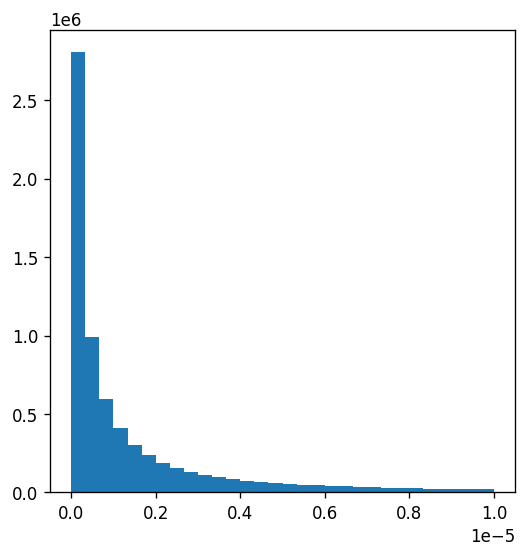

In [6]:
plt.figure(figsize=(5,5), dpi=DPI)
plt.hist(response.flatten()[response.flatten()>0], bins=30, range=(0,0.00001)) #for harris
# plt.hist(response.flatten()[response.flatten()>0], bins=30, range= (0,0.05)) #for shitomasi


### Threshold the corners and visualise it

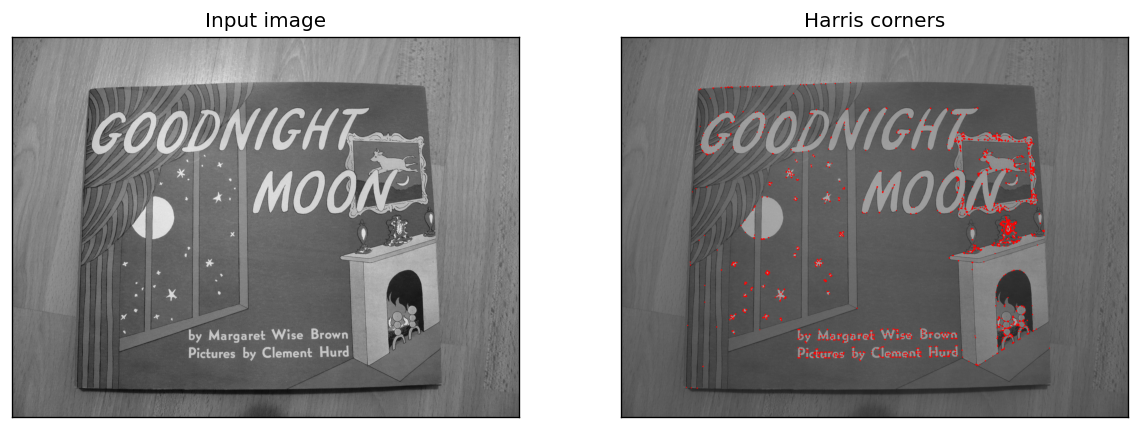

In [7]:
# TODO 
threshold = 0.003 #for harris
# threshold = 0.02 #for shitomasi



corners =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mask = response>threshold

x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow((input_img * 255).astype(np.uint8), cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Harris corners')
plt.show()

### Apply NMS

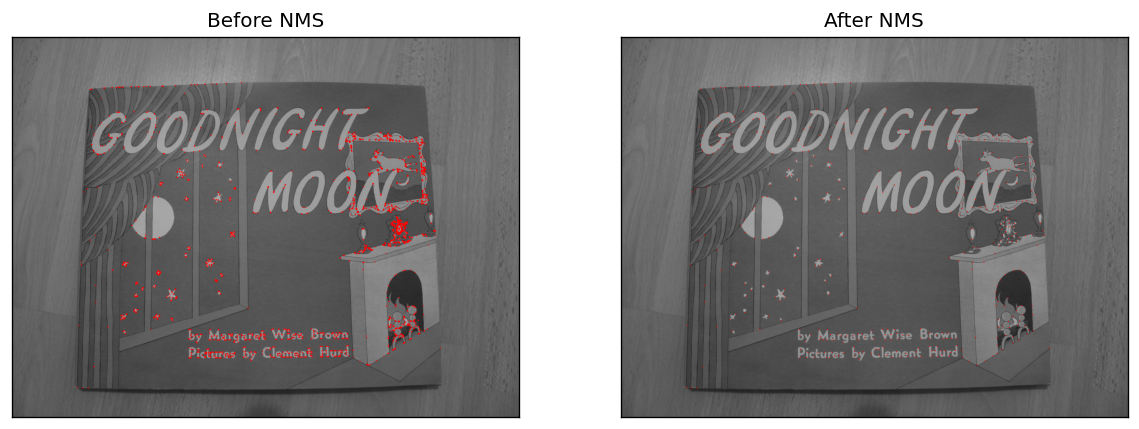

In [8]:
from scipy.ndimage import maximum_filter
# TODO

# Apply non-maximum suppression
max_filtered = maximum_filter(response, size=40, mode='constant')
mask = (response == max_filtered) & (response > threshold)


corners_filter =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners_filter, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Before NMS')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners_filter)
plt.title('After NMS')
plt.show()